In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsa
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from scipy import stats
import yfinance as yf

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import VECM

# set pd/np parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(legacy='1.21')
np.set_printoptions(suppress=True)

# set plt/sns parameters
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("whitegrid")

In [3]:
def plot_acf_pacf(series):
    fig, axs = plt.subplots(2,1)
    plot_acf(series, ax=axs[0])
    plot_pacf(series, ax=axs[1])
    plt.tight_layout()
    plt.show()
    
def adf_test(timeseries, **kwargs):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, **kwargs)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries, **kwargs):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, **kwargs)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

# Проблема 1

### (1) Read the dataset

In [5]:
df_msft = pd.read_csv('daily_MSFT.csv', parse_dates=['timestamp'], index_col='timestamp')
df_msft = df_msft.sort_index()

df_msft

,open,high,low,close,volume
timestamp,,,,,
1998-01-02,129.630,131.500,129.500,131.130,4968500
1998-01-05,131.250,133.630,127.870,130.380,10047200
1998-01-06,129.750,133.000,129.250,131.130,8479300
1998-01-07,129.880,131.190,127.500,129.560,7686600
1998-01-08,128.630,132.130,127.500,130.500,9702400
...,...,...,...,...,...
2019-02-01,103.775,104.100,102.350,102.780,35535690
2019-02-04,102.870,105.800,102.770,105.740,31315282
2019-02-05,106.060,107.270,105.960,107.220,27325365


### (2) Calculate the logarithmic returns

In [7]:
df_msft['log_return'] = np.log(df_msft['close']).diff()

df_msft

,open,high,low,close,volume,log_return
timestamp,,,,,,
1998-01-02,129.630,131.500,129.500,131.130,4968500,NaN
1998-01-05,131.250,133.630,127.870,130.380,10047200,-0.006
1998-01-06,129.750,133.000,129.250,131.130,8479300,0.006
1998-01-07,129.880,131.190,127.500,129.560,7686600,-0.012
1998-01-08,128.630,132.130,127.500,130.500,9702400,0.007
...,...,...,...,...,...,...
2019-02-01,103.775,104.100,102.350,102.780,35535690,-0.016
2019-02-04,102.870,105.800,102.770,105.740,31315282,0.028
2019-02-05,106.060,107.270,105.960,107.220,27325365,0.014


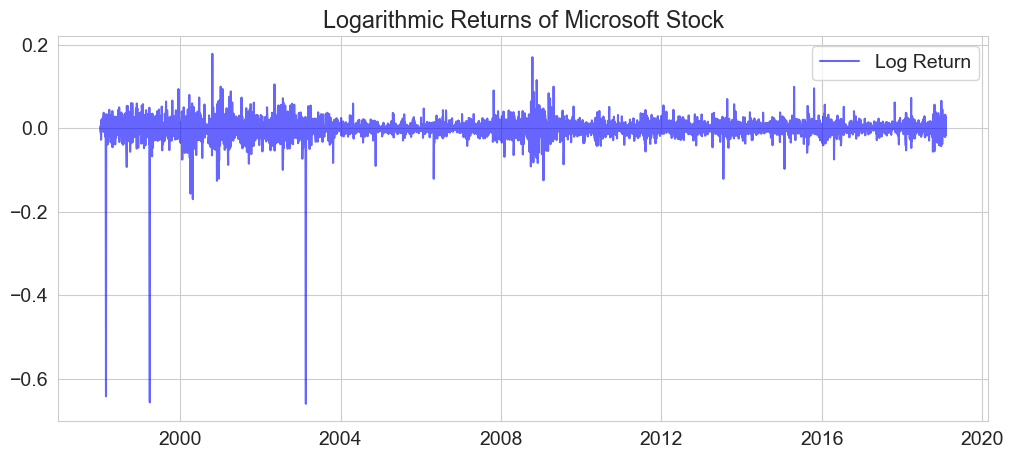

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df_msft['log_return'], label='Log Return', color = 'blue', alpha = 0.6)
plt.title('Logarithmic Returns of Microsoft Stock')
plt.legend()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -44.084
p-value                          0.000
#Lags Used                       2.000
Number of Observations Used   5305.000
Critical Value (1%)             -3.432
Critical Value (5%)             -2.862
Critical Value (10%)            -2.567
dtype: float64
Results of KPSS Test:
Test Statistic          0.414
p-value                 0.071
Lags Used               2.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64


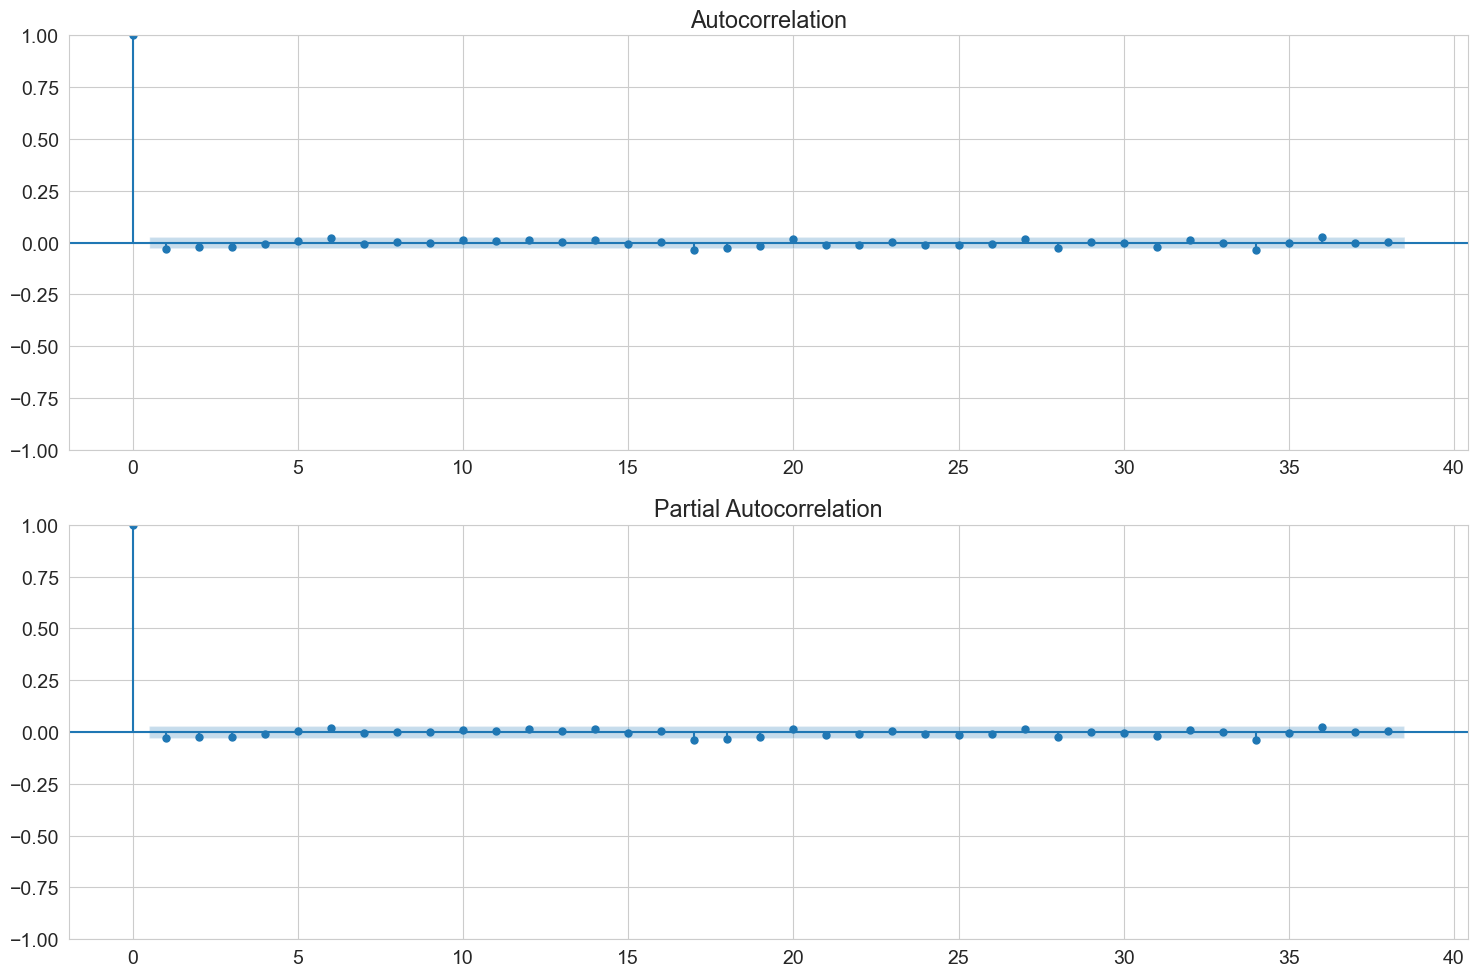

In [11]:
# Тесты на стационарность, чтобы убедиться, что ряд стал стационарным после дельты

adf_test(df_msft['log_return'].dropna())
kpss_test(df_msft['log_return'].dropna())
plot_acf_pacf(df_msft['log_return'].dropna())

Что видно из графика: 

1) Волатильность не выглядит постоянной, видны кластеры
2) Есть 3 сильных отрицательных выброса, которые приводят к повышенной волатильности (leverage effect)
3) Из ACF и PACF видно, что лаги не являются значимыми, бессмысленно строить модели типа ARMA. Но можно моделировать волатильность

### (3) EWMA

In [13]:
lambda_ = 0.94
df_msft['ewma_vol'] = df_msft['log_return'].ewm(span=(2/(1-lambda_)-1)).std()

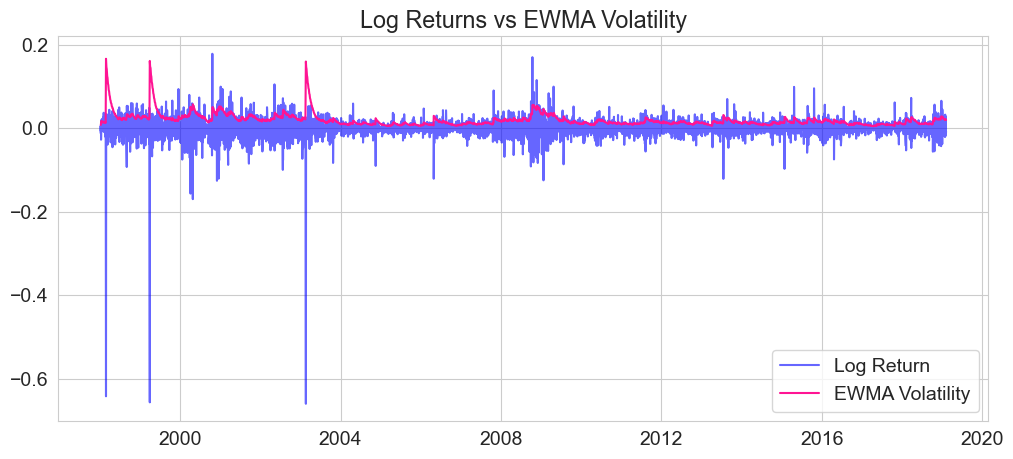

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df_msft['log_return'], label='Log Return', color = 'blue', alpha = 0.6)
plt.plot(df_msft['ewma_vol'], label='EWMA Volatility', color='deeppink')
plt.title('Log Returns vs EWMA Volatility')
plt.legend()
plt.show()

Волатильность действительно непостоянная, можно выделить условно 4 кластера, где волатильность росла (1998, 1999, 2003, 2009)

### (4)  Realized volatility

In [17]:
df_msft['s2'] = np.log(df_msft['high']) - np.log(df_msft['low'])

df_msft

,open,high,low,close,volume,log_return,ewma_vol,s2
timestamp,,,,,,,,
1998-01-02,129.630,131.500,129.500,131.130,4968500,NaN,NaN,0.015
1998-01-05,131.250,133.630,127.870,130.380,10047200,-0.006,NaN,0.044
1998-01-06,129.750,133.000,129.250,131.130,8479300,0.006,0.008,0.029
1998-01-07,129.880,131.190,127.500,129.560,7686600,-0.012,0.009,0.029
1998-01-08,128.630,132.130,127.500,130.500,9702400,0.007,0.009,0.036
...,...,...,...,...,...,...,...,...
2019-02-01,103.775,104.100,102.350,102.780,35535690,-0.016,0.021,0.017
2019-02-04,102.870,105.800,102.770,105.740,31315282,0.028,0.022,0.029
2019-02-05,106.060,107.270,105.960,107.220,27325365,0.014,0.021,0.012


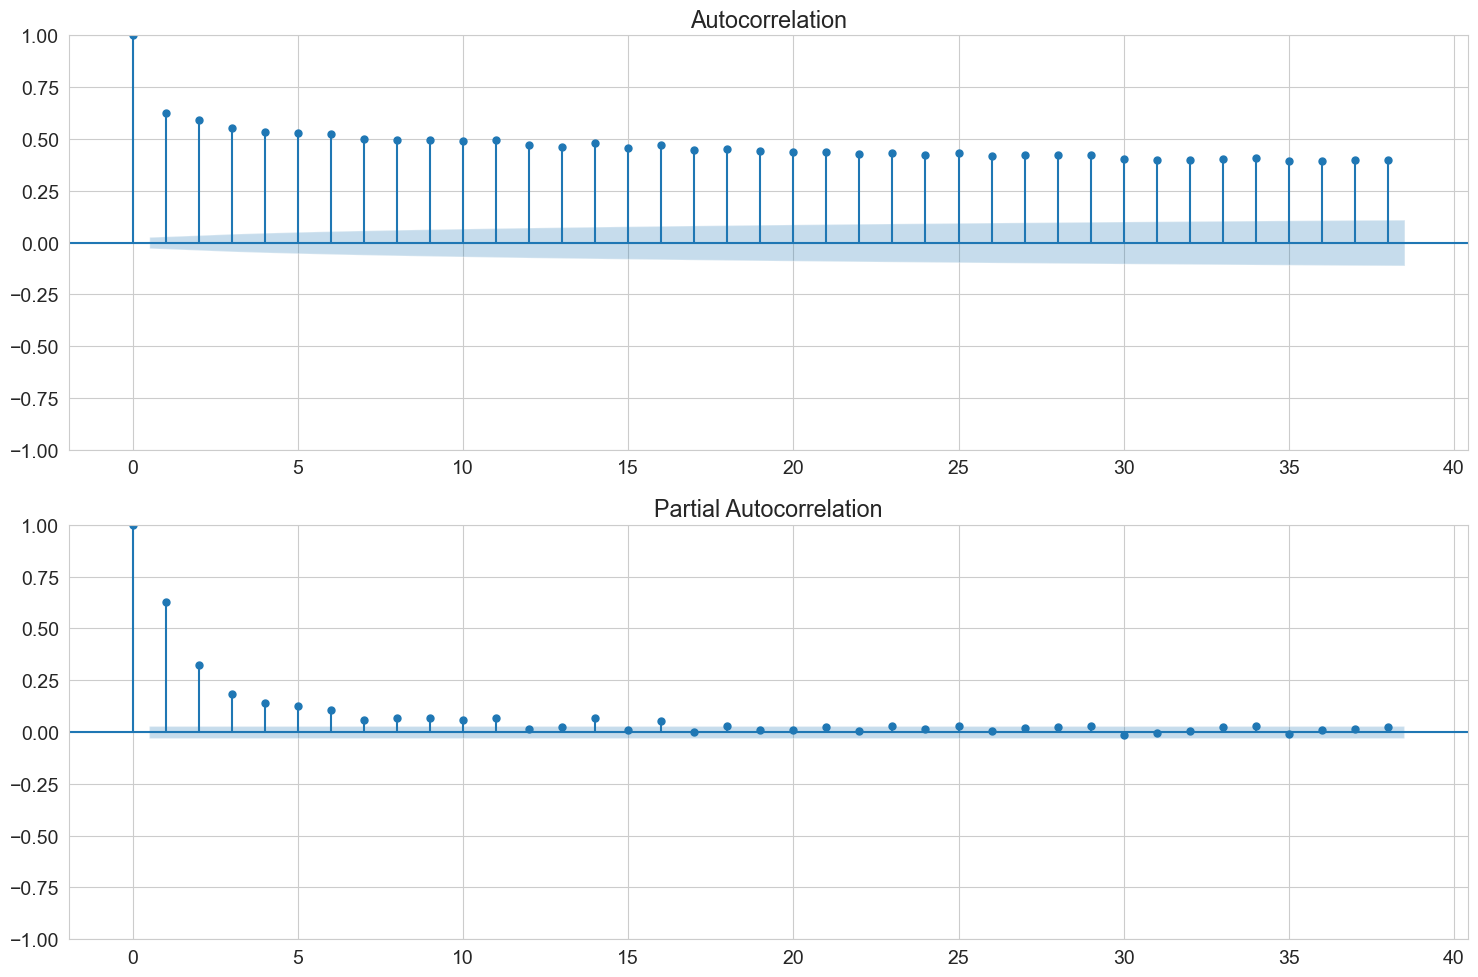

In [19]:
plot_acf_pacf(df_msft['s2'].dropna())

ACF убывает медленно, как будто бы не экспоненциально. Поскольку модель ARMA, но графикам ACF и PACF сказать трудно

In [21]:
# выбираем лучшее BIC

results_bic = {}
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_msft['s2'].dropna(), order=(p, 0, q)).fit()
            results_bic[(p, q)] = model.bic
        except:
            continue

best_bic_order = min(results_bic, key=results_bic.get)
print(f'Best ARMA order based on BIC: {best_bic_order}, BIC: {results_bic[best_bic_order]}')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

Best ARMA order based on BIC: (1, 4), BIC: -33869.52216741601


Выбирала модель по информационному критерию BIC. Лучший по BIC - ARIMA (1,0,4)

In [28]:
model_arma = ARIMA(df_msft['s2'].dropna(), order= (1,0,4)).fit()
model_arma.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     s2   No. Observations:                 5309
Model:                 ARIMA(1, 0, 4)   Log Likelihood               16964.781
Date:                Fri, 21 Feb 2025   AIC                         -33915.562
Time:                        02:46:20   BIC                         -33869.522
Sample:                             0   HQIC                        -33899.475
                               - 5309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0228      0.003      7.093      0.000       0.017       0.029
ar.L1          0.9907      0.002    504.686      0.000       0.987       0.995
ma.L1         -0.7008      0.010    -70.932      0.000      -0.720      -0.681
ma.L2         -0.0398      0.013     -3.050      0.002      -0.065      -0.014
ma.L3         -0.0603      0.014     -4.375      0.000      -0.087      -0.033
ma.L4         -0.0295      0.012     -2.516      0.012      -0.052      -0.007
sigma2      9.814e-05   1.07e-06     91.716      0.000     9.6e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):             13793.22
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### (5) Forecasts

In [43]:
forecast_steps = 14
forecast_ewma = [df_msft['ewma_vol'].iloc[-1]] * forecast_steps
forecast_arma = model_arma.forecast(steps=forecast_steps)
dates_forecast = pd.date_range(df_msft.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Создание таблицы прогнозов
df_forecast = pd.DataFrame({'Date': dates_forecast, 'EWMA Forecast': forecast_ewma, 'ARMA Forecast': forecast_arma.values})
df_forecast

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Date,EWMA Forecast,ARMA Forecast
0,2019-02-08,0.020,0.017
1,2019-02-09,0.020,0.018
2,2019-02-10,0.020,0.018
3,2019-02-11,0.020,0.018
4,2019-02-12,0.020,0.018
5,2019-02-13,0.020,0.018
6,2019-02-14,0.020,0.018
7,2019-02-15,0.020,0.019
8,2019-02-16,0.020,0.019
9,2019-02-17,0.020,0.019


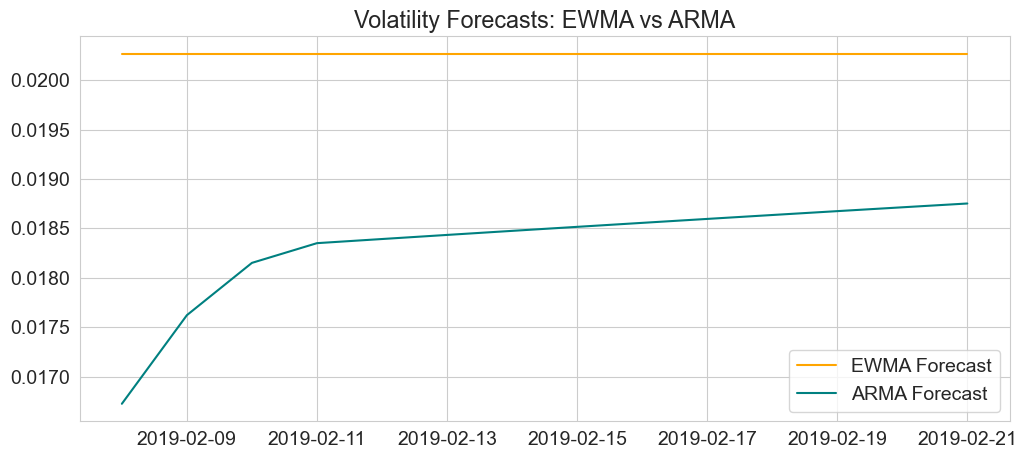

In [62]:
# График прогнозов
plt.figure(figsize=(12, 5))
plt.plot(dates_forecast, forecast_ewma, label='EWMA Forecast', color='orange')
plt.plot(dates_forecast, forecast_arma, label='ARMA Forecast', color='teal')
plt.title('Volatility Forecasts: EWMA vs ARMA')
plt.legend()
plt.show()

Прогноз по EWMA - константа, зависит только от T. Модель realized volatility ведет себя по-другому: прогноз меняется, постепенно приближаясь к некоторому значению; коэффициент при переменной из части AR значим, лаг (предыдущее значение) хорошо объясняет и предсказывает будущие значения 

# Проблема 2

### (1) Read the dataset

In [37]:
df_bonds = pd.read_csv('bondreturns.txt',  sep='\t')
df_bonds['date'] = pd.to_datetime(df_bonds[['year', 'month']].assign(day=1)) # к каждому месяцу устанавливаем 1 число
df_bonds.set_index('date', inplace=True)

df_bonds

,year,month,m1_12,m24_36,m48_60,m61_120
date,,,,,,
1952-01-01,1952,1,0.002,0.005,0.007,0.004
1952-02-01,1952,2,0.001,0.002,0.002,-0.002
1952-03-01,1952,3,0.002,0.004,0.006,0.007
1952-04-01,1952,4,0.001,0.002,0.006,0.006
1952-05-01,1952,5,0.001,0.001,0.001,0.002
...,...,...,...,...,...,...
2003-08-01,2003,8,0.000,-0.003,-0.004,-0.001
2003-09-01,2003,9,0.002,0.016,0.031,0.030
2003-10-01,2003,10,0.000,-0.007,-0.014,-0.013


#### Plot

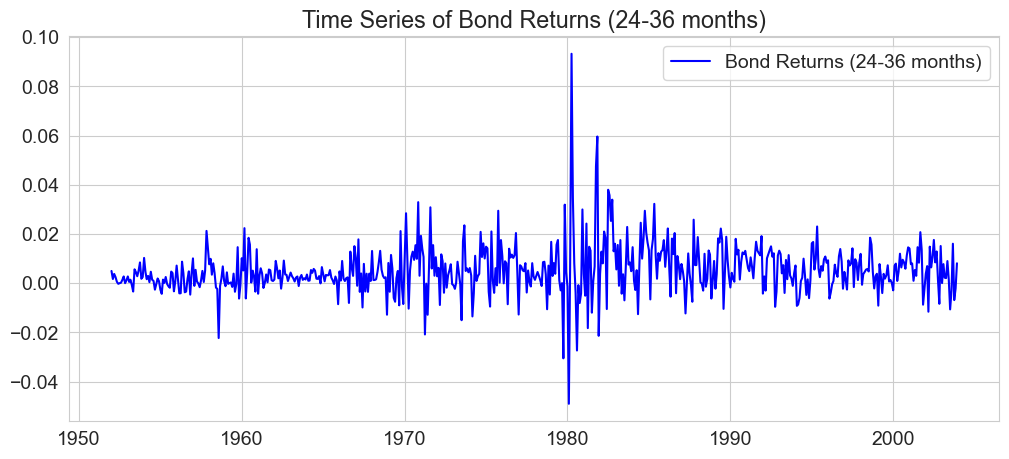

In [67]:
plt.figure(figsize=(12, 5))
plt.plot(df_bonds['m24_36'], label='Bond Returns (24-36 months)', color='blue')
plt.title('Time Series of Bond Returns (24-36 months)')
plt.legend()
plt.show()

#### Histogram

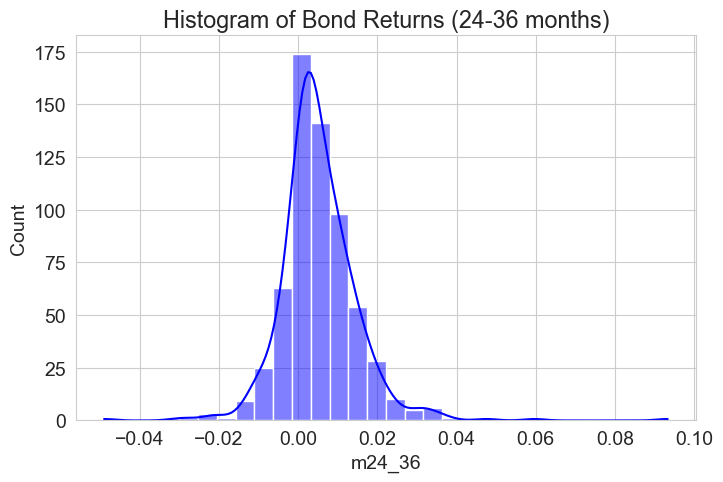

In [69]:
plt.figure(figsize=(8, 5))
sns.histplot(df_bonds['m24_36'], bins=30, kde=True, color='blue')
plt.title('Histogram of Bond Returns (24-36 months)')
plt.show()

Да, наблюдаются особенности финансовых рядов, которые мы наблюдали в классе

1) кластеризация волатильности (невысокая около 1965-х и высокая в 1980-х); связано с ДКП
2) несимметричное распределение, есть смещение относительно среднего
3) тяжелые хвосты
4) leverage effect: волатильность сильнее растет, если шок отрицательный, и меньше растет, если шок положительный

### (2) Report the skewness and kurtosis of the bonds

In [78]:
from scipy.stats import skew, kurtosis

skewness = skew(df_bonds['m24_36']).round(3)
kurtosis = kurtosis(df_bonds['m24_36']).round(3)

print(f"Skewness of m24_36: {skewness}")
print(f"Kurtosis of m24_36: {kurtosis}")

Skewness of m24_36: 1.402
Kurtosis of m24_36: 12.978


Skewness подтверждает смещение относительно среднего, kursosis > 3 говорит о наличии тяжелых хвостов

### (3) Return series is a white noise?

#### Смотрим сначала по ACF, PACF

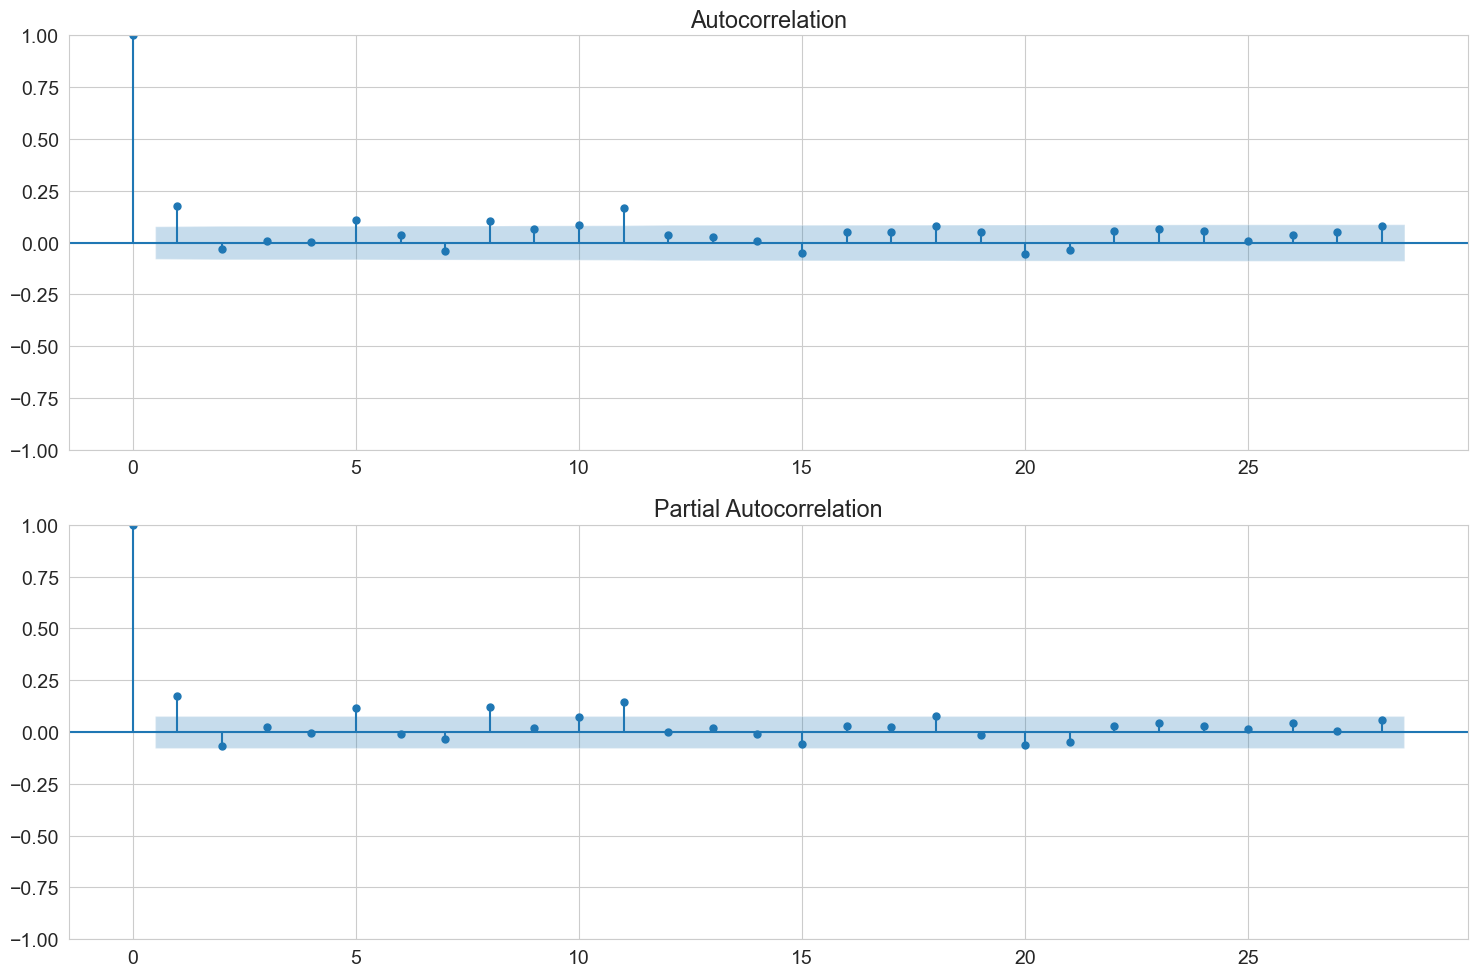

In [85]:
plot_acf_pacf(df_bonds['m24_36'].dropna())

Первый лаг лежит за пределами доверительного интервала, вряд ли белый шум

#### Тест Льюнга-Бокса

In [89]:
acorr_ljungbox(df_bonds['m24_36'], lags=15)

,lb_stat,lb_pvalue
1,19.351,0.000
2,19.997,0.000
3,20.024,0.000
4,20.027,0.000
5,27.815,0.000
6,28.574,0.000
7,29.519,0.000
8,36.368,0.000
9,38.906,0.000
10,43.349,0.000


Нулевая гипотеза о том, что ряд - белый шум, отвергается

#### Подбираем порядок ARMA по BIC

In [94]:
results_bic = {}
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_bonds['m24_36'].dropna(), order=(p, 0, q)).fit()
            results_bic[(p, q)] = model.bic
        except:
            continue

best_bic_order = min(results_bic, key=results_bic.get)
print(f'Best ARMA order based on BIC: {best_bic_order}, BIC: {results_bic[best_bic_order]}')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

Best ARMA order based on BIC: (0, 1), BIC: -3986.4587393332336


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


По BIC, подходящей моделью оказалась ARMA (0,1), то есть процесс MA(1)

In [111]:
model_bond_arma = ARIMA(df_bonds['m24_36'].dropna(), order= (0,0,1)).fit()
model_bond_arma.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 m24_36   No. Observations:                  624
Model:                 ARIMA(0, 0, 1)   Log Likelihood                2002.884
Date:                Fri, 21 Feb 2025   AIC                          -3999.767
Time:                        11:47:50   BIC                          -3986.459
Sample:                    01-01-1952   HQIC                         -3994.596
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.000     10.633      0.000       0.004       0.006
ma.L1          0.1887      0.026      7.344      0.000       0.138       0.239
sigma2      9.535e-05   2.28e-06     41.764      0.000    9.09e-05    9.98e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4052.69
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### (4) Test whether there is an ARCH effect

In [121]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_bond_arma.resid)

(67.41402155752421,
 1.3961498536045318e-10,
 7.437193159440937,
 3.409097308169113e-11)

Второе значение - это p-value. P-value < 5%, нулевая гипотеза об отсутствии ARCH эффекта отвергается. Имеет смысл строить ARCH модели

### (5) Estimate the ARCH(4)

In [128]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.9/948.9 kB 210.3 kB/s eta 0:00:0000:0100:01


In [130]:
from arch import arch_model

In [152]:
arch_model_4 = arch_model(df_bonds['m24_36'], vol='ARCH', p=4, q=0).fit()
arch_model_4.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 54430499899.755165
Iteration:      2,   Func. Count:     23,   Neg. LLF: 9685661.087389644
Iteration:      3,   Func. Count:     36,   Neg. LLF: -2095.356706146629
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2095.3567061210197
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 3


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.879e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 m24_36   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2095.36
Distribution:                  Normal   AIC:                          -4178.71
Method:            Maximum Likelihood   BIC:                          -4152.10
                                        No. Observations:                  624
Date:                Fri, Feb 21 2025   Df Residuals:                      623
Time:                        12:15:27   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.1656e-03  3.871e-04     10.760  5.295e-27 [3.407e-03,4.924e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.4578e-05  3.662e-06      9.443  3.608e-21 [2.740e-05,4.175e-05]
alpha[1]       0.1625  5.994e-02      2.711  6.708e-03   [4.502e-02,  0.280]
alpha[2]       0.1625  6.348e-02      2.560  1.047e-02   [3.808e-02,  0.287]
alpha[3]       0.1625      0.111      1.460      0.144  [-5.570e-02,  0.381]
alpha[4]       0.1625  9.363e-02      1.736  8.265e-02  [-2.102e-02,  0.346]
============================================================================

Covariance estimator: robust
"""

Предупреждение высвечивается, скорее всего, его стоит послушать. С таким же сталкивались на семинаре. У умножения на 100 есть логическая интерпретация - типа процент

In [158]:
arch_model_4 = arch_model(df_bonds['m24_36'] * 100, vol='ARCH', p=4, q=0).fit()
arch_model_4.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 63364.01982279003
Iteration:      2,   Func. Count:     19,   Neg. LLF: 35732.550116027734
Iteration:      3,   Func. Count:     27,   Neg. LLF: 10930.451609880607
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1394.315838608757
Iteration:      5,   Func. Count:     45,   Neg. LLF: 890.1723174086551
Iteration:      6,   Func. Count:     54,   Neg. LLF: 859.6510118485423
Iteration:      7,   Func. Count:     63,   Neg. LLF: 779.894483951651
Iteration:      8,   Func. Count:     71,   Neg. LLF: 776.3664531765257
Iteration:      9,   Func. Count:     78,   Neg. LLF: 776.3664387276091
Iteration:     10,   Func. Count:     84,   Neg. LLF: 776.3664387275921
Optimization terminated successfully    (Exit mode 0)
            Current function value: 776.3664387276091
            Iterations: 10
            Function evaluations: 84
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 m24_36   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -776.366
Distribution:                  Normal   AIC:                           1564.73
Method:            Maximum Likelihood   BIC:                           1591.35
                                        No. Observations:                  624
Date:                Fri, Feb 21 2025   Df Residuals:                      623
Time:                        12:17:40   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4027  4.239e-02      9.500  2.099e-21 [  0.320,  0.486]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2806  5.906e-02      4.751  2.023e-06    [  0.165,  0.396]
alpha[1]       0.1651  5.760e-02      2.866  4.153e-03  [5.220e-02,  0.278]
alpha[2]       0.2254  7.751e-02      2.908  3.635e-03  [7.350e-02,  0.377]
alpha[3]       0.1687      0.111      1.525      0.127 [-4.808e-02,  0.385]
alpha[4]       0.1952      0.111      1.766  7.742e-02 [-2.145e-02,  0.412]
===========================================================================

Covariance estimator: robust
"""

#### Прогноз

In [190]:
arch_forecast = arch_model_4.forecast(horizon=10)
arch_forecast.mean.transpose()

date,2003-12-01
h.01,0.403
h.02,0.403
h.03,0.403
h.04,0.403
h.05,0.403
h.06,0.403
h.07,0.403
h.08,0.403
h.09,0.403
h.10,0.403


In [192]:
arch_forecast.variance.transpose()

date,2003-12-01
h.01,0.875
h.02,0.756
h.03,0.704
h.04,0.748
h.05,0.861
h.06,0.858
h.07,0.880
h.08,0.910
h.09,0.942
h.10,0.957


### (6) Estimate the GARCH(1, 1)

In [172]:
garch_model_11 = arch_model(df_bonds['m24_36'] * 100, vol='Garch', p=1, q=1).fit()
garch_model_11.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 61720.94627314239
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1101370.0129545387
Iteration:      3,   Func. Count:     22,   Neg. LLF: 761.6001278498716
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1969.2040040417687
Iteration:      5,   Func. Count:     36,   Neg. LLF: 748.2214375386252
Iteration:      6,   Func. Count:     41,   Neg. LLF: 748.8896673995187
Iteration:      7,   Func. Count:     47,   Neg. LLF: 748.2089708043156
Iteration:      8,   Func. Count:     52,   Neg. LLF: 748.2089235542953
Iteration:      9,   Func. Count:     57,   Neg. LLF: 748.2089229452781
Optimization terminated successfully    (Exit mode 0)
            Current function value: 748.2089229452781
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 m24_36   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -748.209
Distribution:                  Normal   AIC:                           1504.42
Method:            Maximum Likelihood   BIC:                           1522.16
                                        No. Observations:                  624
Date:                Fri, Feb 21 2025   Df Residuals:                      623
Time:                        12:27:06   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3595  3.684e-02      9.758  1.701e-22 [  0.287,  0.432]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0104  7.858e-03      1.327      0.184 [-4.971e-03,2.583e-02]
alpha[1]       0.1404  3.755e-02      3.740  1.843e-04    [6.683e-02,  0.214]
beta[1]        0.8596  3.171e-02     27.109 7.806e-162      [  0.797,  0.922]
=============================================================================

Covariance estimator: robust
"""

In [186]:
garch_forecast = garch_model_11.forecast(horizon=10)
garch_forecast.mean.transpose()

date,2003-12-01
h.01,0.359
h.02,0.359
h.03,0.359
h.04,0.359
h.05,0.359
h.06,0.359
h.07,0.359
h.08,0.359
h.09,0.359
h.10,0.359


In [194]:
garch_forecast.variance.transpose()

date,2003-12-01
h.01,0.733
h.02,0.743
h.03,0.754
h.04,0.764
h.05,0.775
h.06,0.785
h.07,0.796
h.08,0.806
h.09,0.816
h.10,0.827


По BIC и AIC, модель GARCH (1,1) лучше

Сравнение прогнозов: по GARCH(1,1) mean выходит немного меньше.

Волатильность в обеих моделях растёт, но в GARCH это происходит чуть медленнее; первое прогнозное значение волатильности в GARCH также меньше

### (7) Construct the standardised residual series for the two estimated models

In [231]:
arch_std_resid = arch_model_4.resid / arch_model_4.conditional_volatility
garch_std_resid = garch_model_11.resid / garch_model_11.conditional_volatility

print('Summary statistics for ARCH(4) standardized residuals:')
print(arch_std_resid.describe())
print ()

print('Summary statistics for GARCH(1,1) standardized residuals:')
print(garch_std_resid.describe())

Summary statistics for ARCH(4) standardized residuals:
count   624.000
mean      0.076
std       0.998
min      -3.899
25%      -0.519
50%       0.001
75%       0.648
max       4.554
dtype: float64

Summary statistics for GARCH(1,1) standardized residuals:
count   624.000
mean      0.102
std       0.999
min      -4.297
25%      -0.493
50%       0.063
75%       0.706
max       3.982
dtype: float64


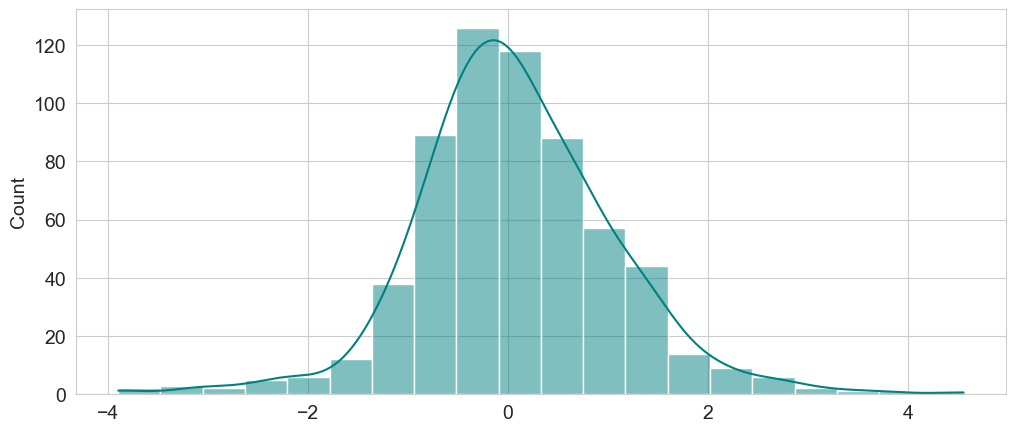

In [262]:
plt.figure(figsize=(12, 5))
sns.histplot(arch_std_resid, bins=20, kde=True, color='teal')
plt.show()

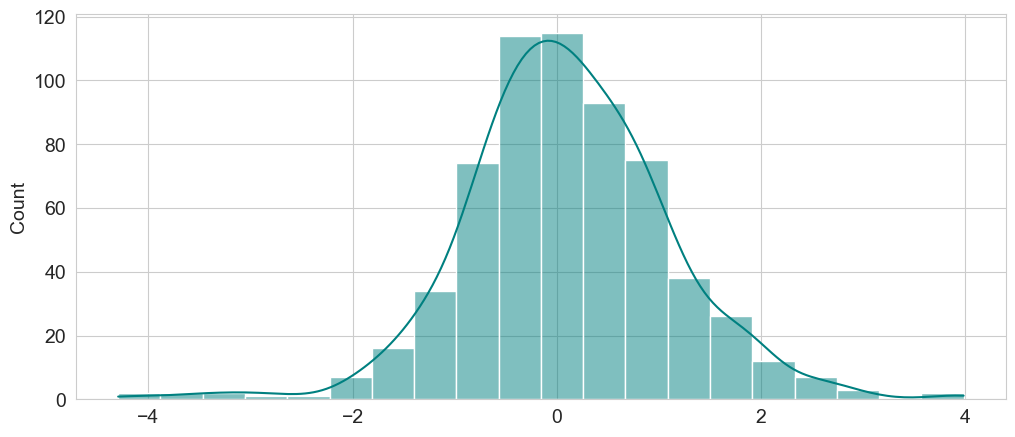

In [264]:
plt.figure(figsize=(12, 5))
sns.histplot(garch_std_resid, bins=20, kde=True, color='teal')
plt.show()

Эти нормированные ошибки должны быть нормальными. Визуально на гистограмме есть некоторые сомнения: хотя среднее 0 (что должно было получиться при нормировке), как будто бы есть некая асимметрия. Можно протестировать на нормальность

In [250]:
print (stats.jarque_bera(arch_std_resid))
print (stats.jarque_bera(garch_std_resid))

SignificanceResult(statistic=104.26494372318191, pvalue=2.2864154311454382e-23)
SignificanceResult(statistic=87.64769787848958, pvalue=9.279919949562022e-20)


p-value < 0, нулевая гипотеза о нормальности остатков отвергается